In [ ]:
!pip install netcdf4
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install utm

In [ ]:
import pandas as pd
import numpy as np
import tqdm
from netCDF4 import Dataset 
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from scipy import interpolate

# ¿Qué son los datos multidimensionales o archivos netcdf's?

Los ficheros necesarios para esta sección se encuentran en: https://drive.google.com/drive/folders/1x0tSx8b15cOX8rvgD0k6cU-6NRnT5pL9?usp=sharing

El netCDF (formulario de datos comunes en red) es un formato de archivo destinado a almacenar datos científicos multidimensionales (variables) como la temperatura, la humedad, la presión, la velocidad del viento y la dirección. Cada una de estas variables se puede mostrar mediante una dimensión (por ejemplo, tiempo)

![texto alternativo](http://www.gisandbeers.com/wp-content/uploads/2018/10/Archivos-NetCDF.jpg)

Lo primero que debemos hacer para visualizar ficheros antes de realizar cualquier tratamiento es visualizarlos, para ello instalaremos en nuestros PC's: https://www.giss.nasa.gov/tools/panoply/

![texto alternativo](https://www.giss.nasa.gov/tools/panoply/panoply_400.jpg)

A continuación se van a realizar diferentes ejemplos de cómo trabajar con esta tipología de datos.


## Lectura de datos netcdf

In [ ]:
dataset=Dataset('Precipitacion_SPAIN_2000.nc')

In [ ]:
 for i in dataset.variables:
    print(i)
 #print (dataset.variables)

A continuación guardamos los datos del netCDF en diferentes variables para poder trabajar desde aquí:

In [ ]:
Precipitacion=dataset.variables['prcp'][:].data
Lon=dataset.variables['lon'][:].data
Lat=dataset.variables['lat'][:].data

In [ ]:
np.shape(Precipitacion)

In [ ]:
# Get some parameters for the Stereographic Projection
lon_0 = Lon.mean()
lat_0 = Lat.mean()

m = Basemap(width=3000000,height=1500000,
            resolution='l',projection='stere',lat_0=lat_0,lon_0=lon_0)

In [ ]:
[XX,YY]=np.meshgrid(Lon, Lat)
xi, yi = m(XX, YY)

In [ ]:
Lon

In [ ]:
XX

In [ ]:
Lat

In [ ]:
YY

Si queremos calcular la lluvia anual acumulada:

In [ ]:
Prec_anual=np.sum(Precipitacion,axis=0)

In [ ]:
np.shape(Prec_anual)

In [ ]:
# Plot Data
cs = m.pcolor(xi,yi,Prec_anual)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('Precipitación anual (mm)')

# Add Title
plt.title('Precipitación anual')

plt.show()

Si queremos calcular la lluvia media diaria:


In [ ]:
Prec_med_diaria=np.mean(Precipitacion,axis=0)

In [ ]:
# Plot Data
cs = m.pcolor(xi,yi,Prec_med_diaria)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('Precipitación media diaria (mm)')

# Add Title
plt.title('Precipitación media diaria')

plt.show()

## ¿Cómo se crea un netCDF?

A continuación vamos a calcular la precipitación media mensual y posteriormente crear un fichero netcdf con estos datos

In [ ]:
time=pd.date_range(start='2000-01-01',end='2000-12-31',freq='D')

In [ ]:
time

In [ ]:
print('Longitud vector tiempo: '+str(len(time)), 'Longitud Netcdf: '+str(len(Precipitacion)))

In [ ]:
Precipitacion_mensual=np.ones((12,len(Lat),len(Lon)))
for i in range (1,13):
  pos=np.where(time.month==i)
  Precipitacion_mensual[i-1,:,:]=np.sum(Precipitacion[pos[0],:,:],axis=0)

In [ ]:
np.shape(Precipitacion_mensual)

In [ ]:
nc = Dataset('Precipitacion_SPAIN_mensual_2000.nc', 'w', format='NETCDF4')
# Global Attributes 
nc.description= 'Contiene la precipitación media mensual del año 2000'  
# nc dimensions
nc.createDimension('lon',  len(Lon))
nc.createDimension('lat',  len(Lat))
nc.createDimension('time',12)
# crear variables
xx_nc=nc.createVariable('lon','float64', ('lon'))
yy_nc=nc.createVariable('lat','float64', ('lat'))
time_nc=nc.createVariable('time','float64',('time'))
Prcp_nc=nc.createVariable('prcp','float64', ('time','lat', 'lon'))
#units
xx_nc.units = 'degrees_east'
yy_nc.units = 'degrees_north'
time_nc.units='months since '+str(2000)+'-01-01'
Prcp_nc.units='mm'
#long_name
xx_nc.long_name = 'longitude coordinate'
yy_nc.long_name = 'latitud coordinate'
time_nc.long_name='meses del año'
Prcp_nc.long_name='Precipitacion mensual'
#fill_value
Prcp_nc.missing_value='-9999'
# calendar
time_nc.calendar = 'proleptic_gregorian'
# rellenar variables
xx_nc[:]=Lon
yy_nc[:]=Lat
Prcp_nc[:]=Precipitacion_mensual
time_nc[:]=np.arange(0,12,1)
nc.close()

# ¿Que hacemos si queremos aumentar la resolución de los datos?
Imaginemos que queremos interpolar estos datos a una resolución 10 veces mayor.

In [ ]:
res=10
xllcorner=np.min(Lon)
yllcorner=np.min(Lat)
ncols=len(Lon)*res
nrows=len(Lat)*res
cellsize=np.abs(Lon[1]-Lon[0])/res

In [ ]:
xx_res = np.linspace(xllcorner, xllcorner + (ncols-1)*cellsize, ncols)
yy_res = np.linspace(yllcorner, yllcorner + (nrows-1)*cellsize, nrows)

In [ ]:
f = interpolate.interp2d(Lon, Lat, Prec_anual, kind='linear')
fnew = f(xx_res, yy_res)

In [ ]:
print(np.shape(Prec_anual),np.shape(fnew))

In [ ]:
[XX_new,YY_new]=np.meshgrid(xx_res,yy_res)
xi_new, yi_new = m(XX_new, YY_new)

In [ ]:
# Plot Data
cs = m.pcolor(xi_new,yi_new,fnew)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('Precipitación media diaria (mm)')

# Add Title
plt.title('Precipitación media anual')

plt.show()

---
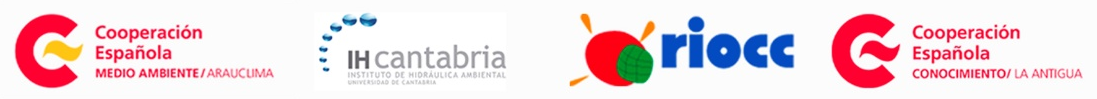

**Este cuaderno de Jupyter ha sido desarrollado por Salvador Navas y Manuel del Jesus.**